## 0. Device selection

In [8]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 1. Data preprocessing

In [9]:
from functools import lru_cache

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split


@lru_cache
def _download_data():
    data = torchvision.datasets.FashionMNIST(
        "path", download=True, transform=transforms.ToTensor()
    )
    return data


def get_train_val_loaders(
    batch_size: int,
    fraction_of_train_set: float = 1.0,
    with_gpu: bool = False
) -> tuple[DataLoader, DataLoader]:
    dataset = _download_data()
    train_size = int(fraction_of_train_set * 0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=with_gpu
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=with_gpu
    )

    return (train_loader, val_loader)

## 2. Data presentation tools

In [10]:
import matplotlib.pyplot as plt


def plot_metrics(results: list[dict[str, float]]):
    x = [i for i in range(len(results))]
    accuracy = [results[i]['accuracy'] for i in x]
    recall = [results[i]['recall'] for i in x]
    f1 = [results[i]['f1'] for i in x]

    plt.figure(figsize=(8, 6))
    plt.plot(x, accuracy, linestyle='-', color='b', label='Accuracy')
    plt.plot(x, recall, linestyle='-', color='r', label='Recall')
    plt.plot(x, f1, linestyle='-', color='g', label='F1 Score')

    plt.xlabel('Epoch')
    plt.ylabel('Metric score')
    plt.title('Plot of metric scores')

    plt.xlim(0, len(results))

    plt.legend()

    plt.grid(True)
    plt.show()


def plot_cost(results: list[dict[str, float]]):
    x = [i for i in range(len(results))]
    cost = [results[i]['cost'] for i in x]

    plt.figure(figsize=(8, 6))
    plt.plot(x, cost, linestyle='-', color='r', label='Cost')

    plt.xlabel('Epoch')
    plt.ylabel('Cost function value')
    plt.title('Plot of cost value over time (epochs)')

    plt.xlim(0, len(results))

    plt.legend()

    plt.grid(True)
    plt.show()


def compare_plots(results_with_titles: list[tuple[dict, str]], cost: bool = False):
    count = len(results_with_titles)
    cols = min(count, 2)
    rows = ((count - 1) // 2) + 1

    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6), squeeze=False)

    for i in range(rows):
        for j in range(cols):
            plot_index = (2 * i) + j

            if plot_index < count:
                ax = axs[i, j]

                res, title = results_with_titles[plot_index]
                x = [k for k in range(len(res))]

                if cost:
                    cost = [res[j]['cost'] for j in x]
                    ax.plot(x, cost, linestyle='-', color='r', label='Cost')
                else:
                    accuracy = [res[j]['accuracy'] for j in x]
                    recall = [res[j]['recall'] for j in x]
                    f1 = [res[j]['f1'] for j in x]

                    ax.plot(x, accuracy, linestyle='-', color='b', label='Accuracy')
                    ax.plot(x, recall, linestyle='-', color='r', label='Recall')
                    ax.plot(x, f1, linestyle='-', color='g', label='F1 Score')

                ax.set_title(title)
                ax.set_xlim(0, len(res))
                ax.legend()
                ax.grid(True)
            else:
                axs[i, j].set_visible(False)

    fig.supxlabel('Epoch', fontsize=12)
    if cost:
        fig.supylabel('Cost function value', fontsize=12)
        fig.suptitle('Plot of cost value over time (epochs)', fontsize=14)
    else:
        fig.supylabel('Metric scores', fontsize=12)
        fig.suptitle('Plot of metric scores over time (epochs)', fontsize=14)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

## 3. Model

In [15]:
from dataclasses import dataclass

import torch
import torch.nn as nn


@dataclass
class ConvLayerConfig:
    in_channels: int
    out_channels: int
    kernel_size: int  # conv filter size
    padding: int = 1  # padding size
    pool_size: int = 2  # pooling window size


class ConvImageClassifier(nn.Module):
    def __init__(
        self,
        output_labels: int,
        conv_layers_config: list[ConvLayerConfig]
    ):
        super().__init__()
        self.conv_layers = nn.Sequential()

        for i in range(len(conv_layers_config)):
            # in_channels = 1 if i == 0 else conv_layers_config[i - 1].out_channels
            self.conv_layers.append(
                nn.Conv2d(
                    in_channels=conv_layers_config[i].in_channels,
                    out_channels=conv_layers_config[i].out_channels,
                    kernel_size=conv_layers_config[i].kernel_size,
                    padding=conv_layers_config[i].padding
                )
            )
            self.conv_layers.append(nn.ReLU())
            self.conv_layers.append(
                nn.MaxPool2d(kernel_size=conv_layers_config[i].pool_size)
            )

        self.flatten = nn.Flatten()
        self.linear_layers = nn.Sequential(
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.Dropout(),
            nn.LazyLinear(output_labels)
        )

        dummy_input = torch.zeros(1, 1, 28, 28)
        with torch.no_grad():
            self._initialize_lazy_layers(dummy_input)

        self.linear_layers.apply(self._init_weights)

    def _initialize_lazy_layers(self, dummy_input):
        x = self.conv_layers(dummy_input)
        x = self.flatten(x)
        _ = self.linear_layers(x)

    def _init_weights(self, module: nn.Module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            nn.init.zeros_(module.bias)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        return self.linear_layers(x)


## 4. Training

In [12]:
import time

from sklearn.metrics import accuracy_score, f1_score, recall_score
from torch.nn.modules import Module
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader


def add_noise_to_batch(batch, noise_std):
    noise = torch.randn_like(batch) * noise_std
    noisy_batch = batch + noise
    return torch.clamp(noisy_batch, 0, 1)


def train_one_epoch(
    model: ConvImageClassifier,
    train_loader: DataLoader,
    loss_fn: Module,
    optimizer: Optimizer,
    device: torch.device,
    train_noise_std: float = 0.0
):
    model.to(device)
    for X, y in train_loader:
        if train_noise_std > 0.0:
            X = add_noise_to_batch(X, train_noise_std)
            y = add_noise_to_batch(y, train_noise_std)

        X, y = X.to(device), y.to(device)
        # Zero gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model(X)

        # Compute the loss and its gradients
        loss = loss_fn(y_pred, y)
        loss.backward()

        # Adjust learning weights
        optimizer.step()


def train_model(
    model: ConvImageClassifier,
    max_epochs: int,
    train_loader: DataLoader,
    val_loader: DataLoader,
    loss_fn: Module,
    optimizer: Optimizer,
    device: torch.device,
    train_noise_std: float = 0.0,
    val_noise_std: float = 0.0,
    debug: bool = False
):
    model.to(device)
    results = []
    prev_avg_val_loss = 0.0
    start = time.time()
    # Initialize training
    for epoch in range(max_epochs):
        elapsed_time = int(time.time() - start)
        print(f"{elapsed_time}s [{epoch + 1}/{max_epochs}] Epoch with {device} device")
        model.train()  # Set model to training mode

        # Train for one epoch
        train_one_epoch(
            model=model,
            train_loader=train_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
            train_noise_std=train_noise_std
        )

        model.eval()
        running_val_loss = 0.0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for X, y in val_loader:
                if val_noise_std > 0.0:
                    X = add_noise_to_batch(X, val_noise_std)
                    y = add_noise_to_batch(y, val_noise_std)

                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                val_loss = loss_fn(y_pred, y)
                running_val_loss += val_loss.item()

                predicted_classes = torch.argmax(y_pred, dim=1)
                all_labels.extend(y.cpu().numpy())
                all_preds.extend(predicted_classes.cpu().numpy())

        # Calculate metrics for the epoch
        accuracy = accuracy_score(all_labels, all_preds)
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')
        avg_val_loss = running_val_loss / len(val_loader)

        results.append({
            "accuracy": accuracy,
            "recall": recall,
            "f1": f1,
            "cost": avg_val_loss
        })

        delta = avg_val_loss - prev_avg_val_loss
        if debug:
            print(f"Epoch [{epoch+1}/{max_epochs}] - avg val loss: {avg_val_loss:.4f} (delta: {delta})")
        prev_avg_val_loss = avg_val_loss

    print("Training complete!")
    return results

## 5. Experiments

In [13]:

train_loader, val_loader = get_train_val_loaders(
    batch_size=12,
    with_gpu=False,
)

model = ConvImageClassifier(
    output_labels=10,
    conv_layers_config=[
        ConvLayerConfig(
            in_channels=1,
            out_channels=32,
            kernel_size=3
        )
    ]
)

optimizer = torch.optim.Adam(model.parameters())

results = train_model(
    model=model,
    max_epochs=4,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=optimizer,
    device=device
)

0s [1/4] Epoch with cpu device
42s [2/4] Epoch with cpu device
82s [3/4] Epoch with cpu device
121s [4/4] Epoch with cpu device
Training complete!


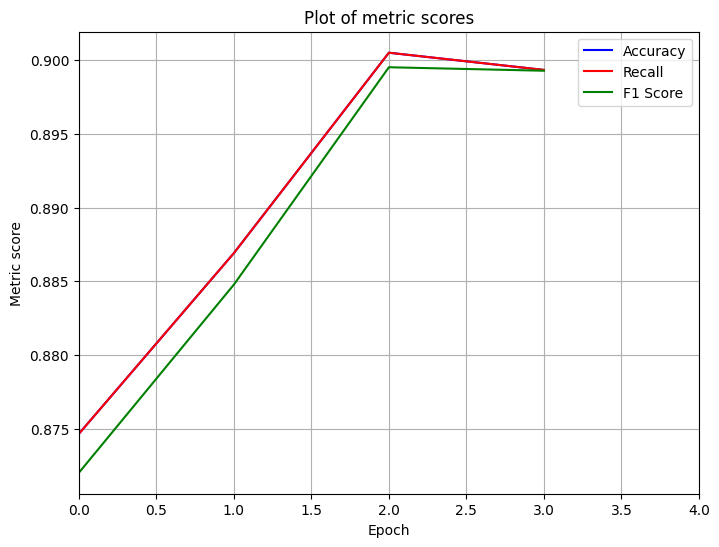

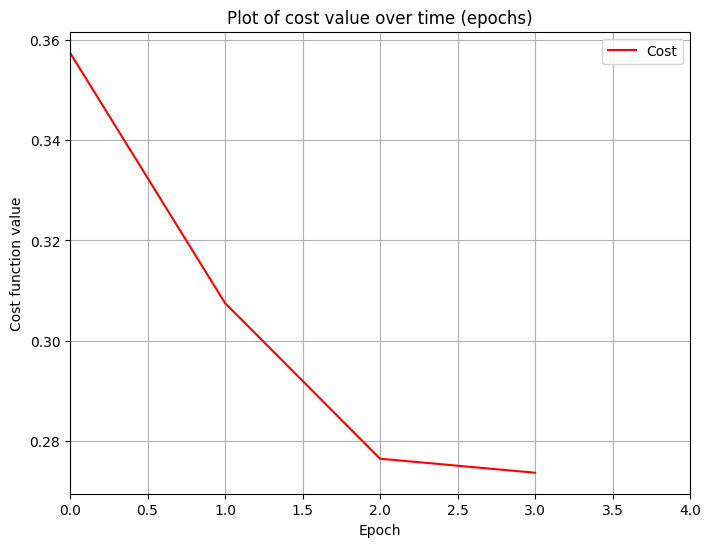

In [14]:
plot_metrics(results)
plot_cost(results)

In [ ]:
from typing import Any

BATCH_SIZE = 16  # arbitraly chosen batch size

def run_experiment(
    param_config: dict[str, Any],
    device: torch.device,
    with_gpu: bool = False
):
    conv_layer_dims: list[tuple[int, int]] = param_config["conv_layer_dims"]
    conv_kernel_size = param_config["conv_kernel_size"]
    pooling_window_size = param_config["pooling_window_size"]
    train_noise_std = param_config["train_noise_std"]
    val_noise_std = param_config["val_noise_std"]

    train_loader, val_loader = get_train_val_loaders(
        batch_size=BATCH_SIZE,
        with_gpu=with_gpu,
    )

    conv_layers_config = []
    for dims in conv_layer_dims:
        in_channels, out_channels = dims
        conv_layers_config.append(ConvLayerConfig(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=conv_kernel_size,
            pool_size=pooling_window_size
        ))

    model = ConvImageClassifier(
        output_labels=10,
        conv_layers_config=conv_layers_config
    )

    optimizer = torch.optim.Adam(model.parameters())
    results = train_model(
        model=model,
        max_epochs=5,
        train_loader=train_loader,
        val_loader=val_loader,
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        device=device,
        train_noise_std=train_noise_std,
        val_noise_std=val_noise_std
    )

    return results

In [ ]:
import itertools


def grid_search(param_grid: dict[str, list[Any]]):
    if torch.cuda.is_available():
        device = torch.device("cuda")
        with_gpu = True
    else:
        device = torch.device("cpu")
        with_gpu = False

    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    with open("results.txt", "w") as f:
        f.write("Grid Search Results\n")
        f.write("=" * 50 + "\n")

        for i, param_config in enumerate(param_combinations, 1):
            print(f"Running experiment {i}/{len(param_combinations)}")

            experiment_results = run_experiment(param_config, device, with_gpu)

            f.write(f"Experiment {i}:\n")
            f.write("Parameters:\n")
            for key, value in param_config.items():
                f.write(f"  {key}: {value}\n")
            f.write("Results:\n")
            f.write(str(experiment_results))
            f.write("-" * 50 + "\n")


In [ ]:
param_grid = {
    "conv_layer_dims": [
        [(1, 16)],
        [(1, 64)],
        [(1, 16), (16, 32)],
        [(1, 32), (32, 64), (64, 128)]
    ],
    "conv_kernel_size": [2, 3, 5],
    "pooling_window_size": [2, 3, 4],
    "train_noise_std": [0, 0.2],
    "val_noise_std": [0, 0.2]
}

grid_search(param_grid)

## 6. Results

In [25]:
import ast
from dataclasses import dataclass
from functools import lru_cache
from pathlib import Path


@dataclass
class ParamsConfig:
    subset_size: float
    batch_size: int
    layer_dims: list[int]
    train_noise_std: float
    val_noise_std: float


@dataclass
class Results:
    params_config: ParamsConfig
    results: list[dict[str, float]]


@lru_cache
def parse_results_file(file_path: Path) -> list[Results]:
    with open(file_path) as f:
        lines = f.readlines()

    all_results = []

    i = 0
    while i < len(lines):
        if lines[i].startswith("Experiment"):
            params = {}
            while i < len(lines) and not lines[i].startswith("Results:"):
                if ":" in lines[i]:
                    key, value = lines[i].split(":", 1)
                    key = key.strip()
                    value = value.strip()
                    if key == "subset_size":
                        params[key] = float(value)
                    elif key == "batch_size":
                        params[key] = int(value)
                    elif key == "layer_dims":
                        # Remove brackets and split
                        params[key] = [int(x.strip()) for x in value.strip('[]').split(',')]
                    elif key == "train_noise_std" or key == "val_noise_std":
                        params[key] = float(value)
                i += 1
            if lines[i].startswith("Results:"):
                i += 1
                results = ast.literal_eval(lines[i][:-51])
            else:
                results = None

            params_config = ParamsConfig(**params)
            all_results.append(Results(
                params_config=params_config,
                results=results
            ))
        i += 1

    return all_results

In [26]:
all_results = parse_results_file(
    file_path = Path("colab_results.txt")
)


def filter_results(**kwargs) -> Results | None:
    for res in all_results:
        flag = 1
        for key, val in kwargs.items():
            if not getattr(res.params_config, key) == val:
                flag *= 0
        if flag == 1:
            return res
    return None

### Hidden layers size

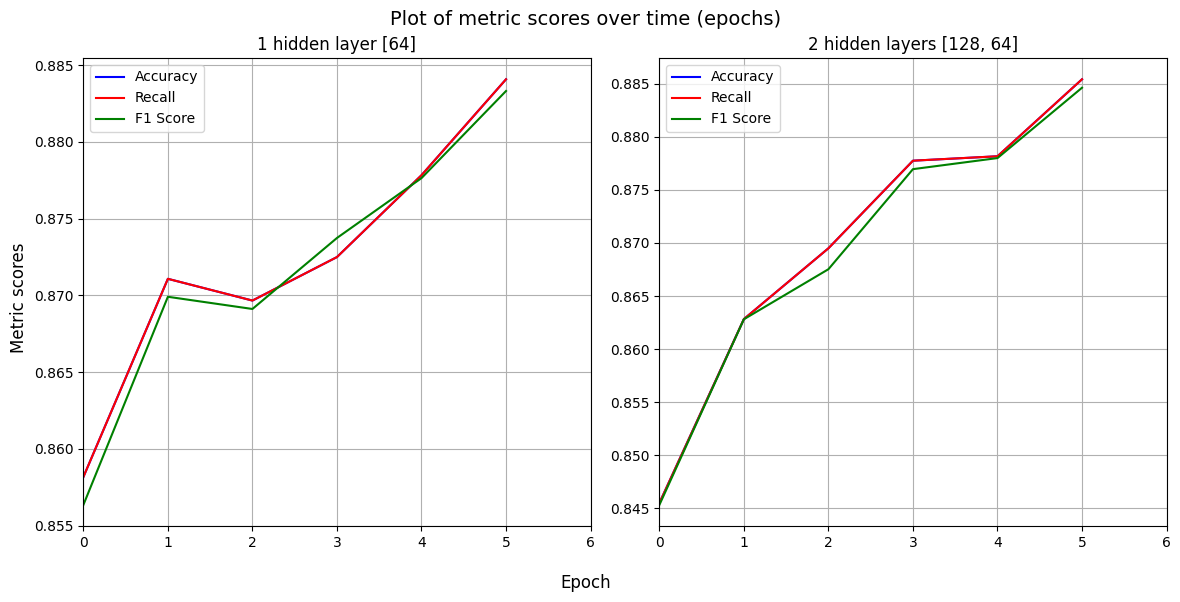

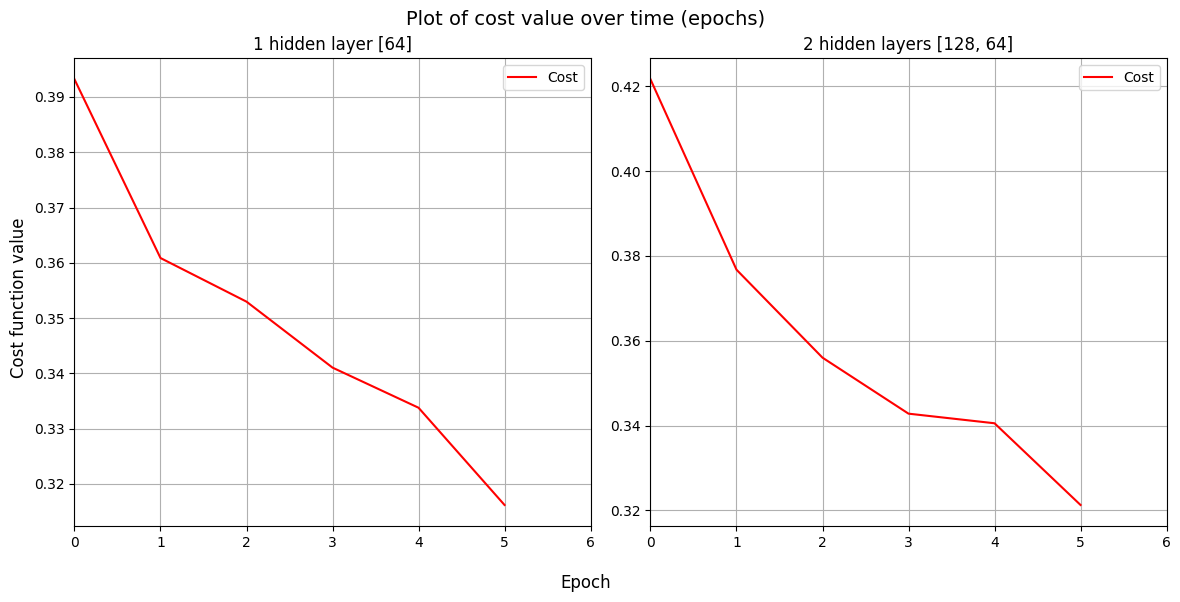

In [ ]:
one_layer_results = filter_results(
    subset_size = 1.0,
    batch_size=12,
    layer_dims = [784, 64, 10],
    train_noise_std=0.0,
    val_noise_std=0.0
)
two_layers_results = filter_results(
    subset_size = 1.0,
    batch_size=12,
    layer_dims = [784, 128, 64, 10],
    train_noise_std=0.0,
    val_noise_std=0.0
)


results_with_titles = [
    (one_layer_results.results, "1 hidden layer [64]"),
    (two_layers_results.results, "2 hidden layers [128, 64]")
]

compare_plots(results_with_titles)
compare_plots(results_with_titles, cost=True)

#### Analysis
The two plots show the performance of the two model configurations: one with a single hidden layer (64 units) and another with two hidden layers (128 and 64 units). The model with 2 hidden layers performs slightly better overall - it achieves higher metric scores compared to the model with a single hidden layer. It shows a steeper increase in the metric score plots and a steeper decrease in the cost plots at the beginning. These differences are not significant and we can assume that both configurations could be used to train a model in this case. However, this task is much more computationally complex and demanding as on the previous lab, so it is likely that using 2 hidden layers improves the model's ability to learn the underlying patterns in the data, leading to better performance in terms of both metric scores and cost function optimisation.

### Batch size

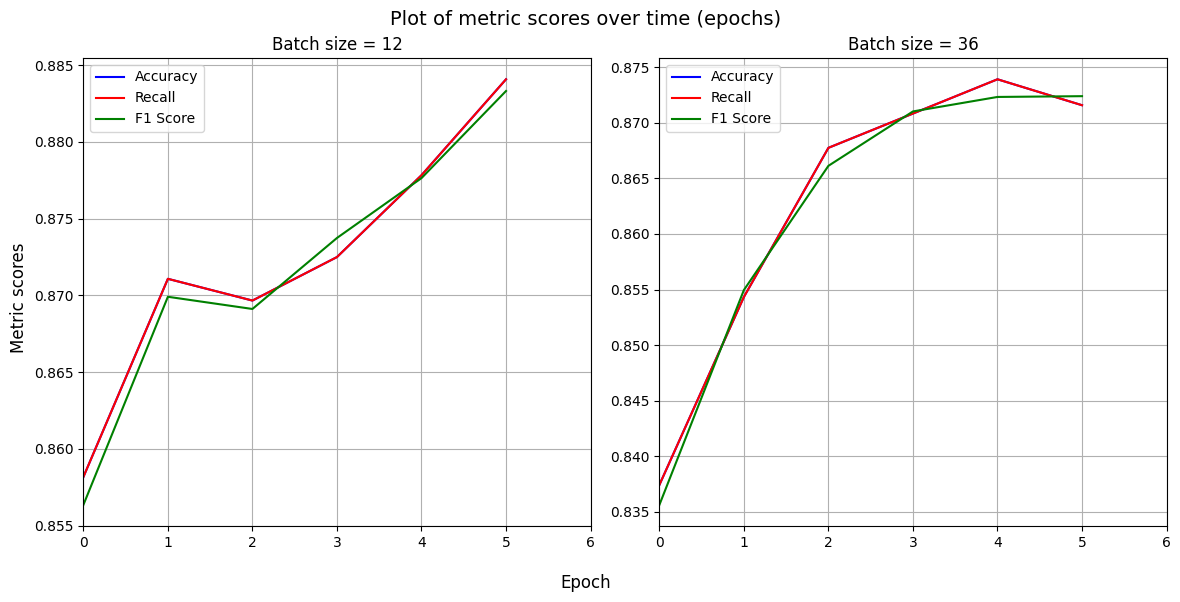

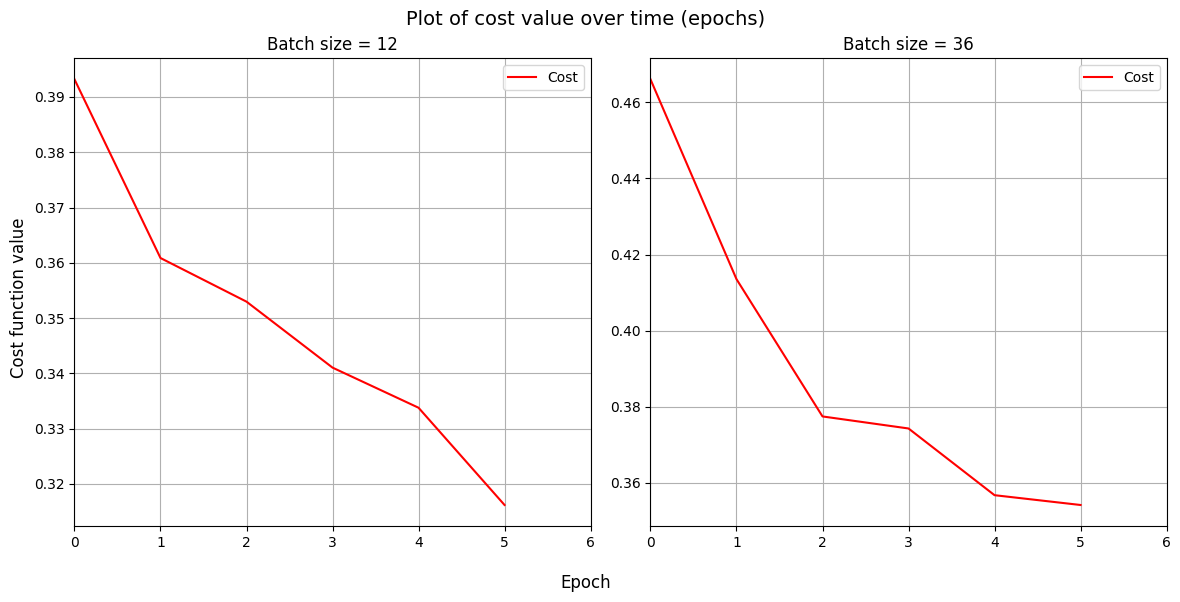

In [ ]:
results_1 = filter_results(
    subset_size = 1.0,
    batch_size=12,
    layer_dims = [784, 64, 10],
    train_noise_std=0.0,
    val_noise_std=0.0
)
results_2 = filter_results(
    subset_size = 1.0,
    batch_size=36,
    layer_dims = [784, 64, 10],
    train_noise_std=0.0,
    val_noise_std=0.0
)


results_with_titles = [
    (results_1.results, "Batch size = 12"),
    (results_2.results, "Batch size = 36")
]

compare_plots(results_with_titles)
compare_plots(results_with_titles, cost=True)

#### Analysis
In this case, we can observe that the choice of batch size can affect both the convergence of the cost function and the performance metrics of the model during the training process. The model with batch size = 36 performed much better in terms of metric values, reaching higher values, but the cost value was overall worse than with batch size = 12. We can say that the model with a larger batch size learned faster, but after ~5 epochs showed some symptoms of overfitting (cost function started to plateau and metric scores decreased). Learning of the smaller batch size model was more stable and would probably be a better choice for this task.

### Train subset fraction

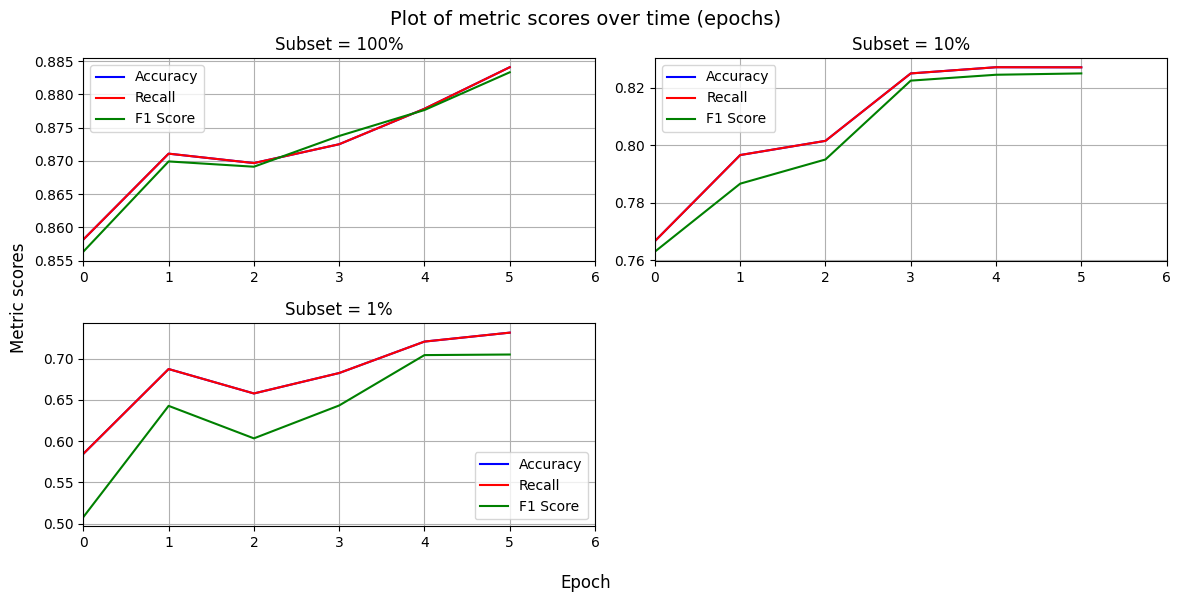

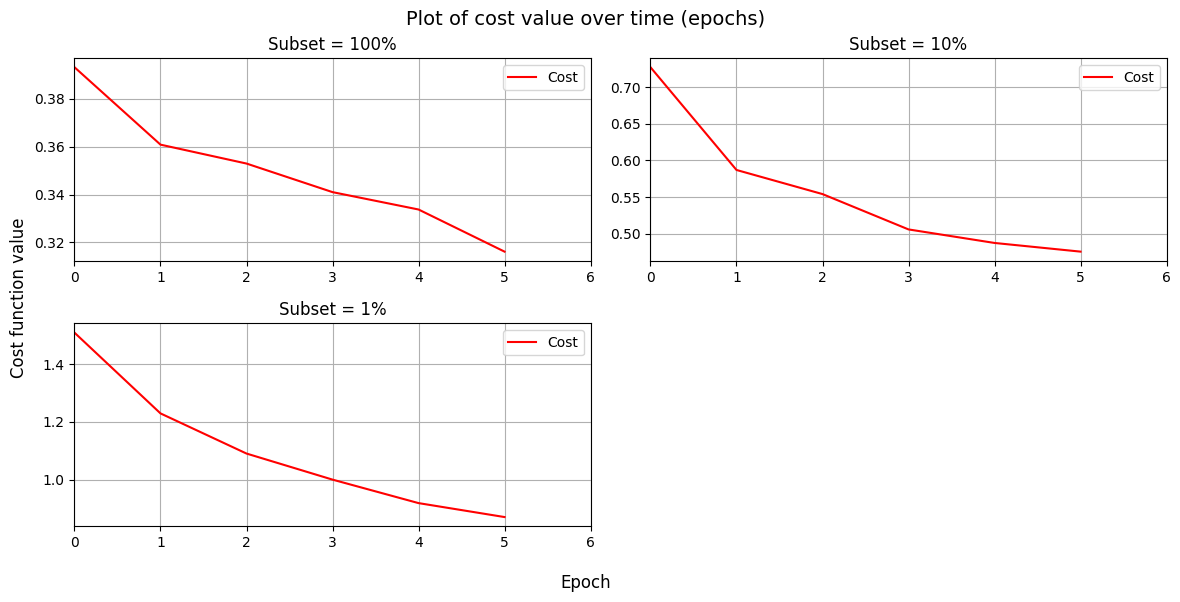

In [ ]:
results_1 = filter_results(
    subset_size = 1.0,
    batch_size=12,
    layer_dims = [784, 64, 10],
    train_noise_std=0.0,
    val_noise_std=0.0
)
results_2 = filter_results(
    subset_size = 0.1,
    batch_size=12,
    layer_dims = [784, 64, 10],
    train_noise_std=0.0,
    val_noise_std=0.0
)
results_3 = filter_results(
    subset_size = 0.01,
    batch_size=12,
    layer_dims = [784, 64, 10],
    train_noise_std=0.0,
    val_noise_std=0.0
)

results_with_titles = [
    (results_1.results, "Subset = 100%"),
    (results_2.results, "Subset = 10%"),
    (results_3.results, "Subset = 1%"),
]

compare_plots(results_with_titles)
compare_plots(results_with_titles, cost=True)

#### Analysis
In this case not much comment is needed - we can clearly see how important the size of a training dataset is. The model trained on a whole dataset performed very well, the model with a dataset fraction = 10% performed acceptable, but the last one - with a dataset fraction = 1% performed really bad, reaching only ~0.7 metric scores and ~0.85 cost value at the end of a training.

### Data noise

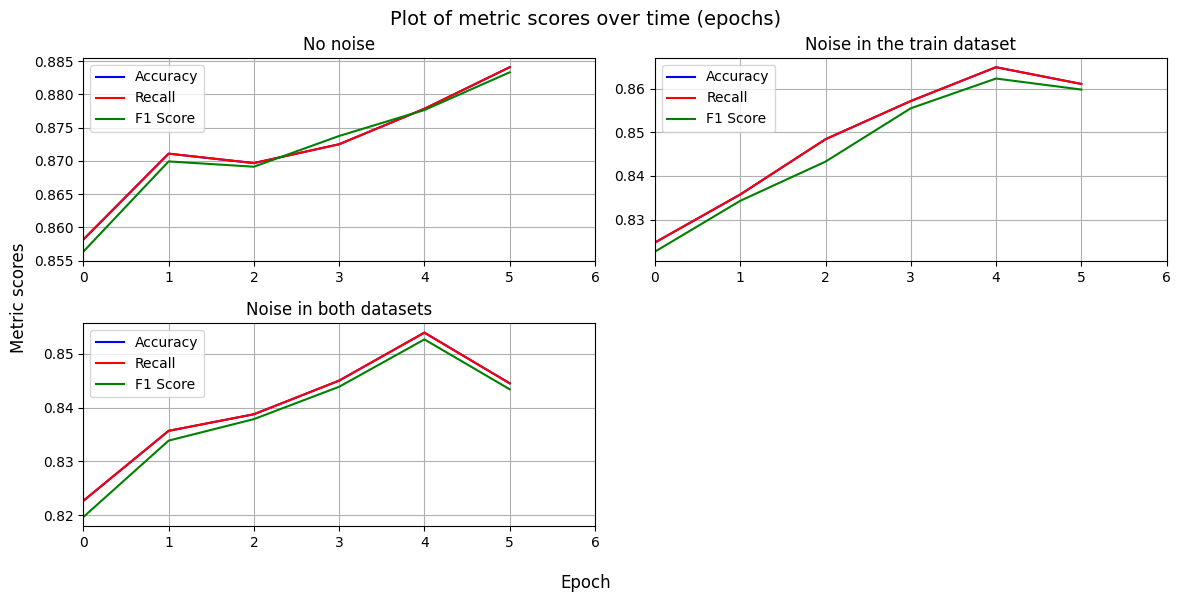

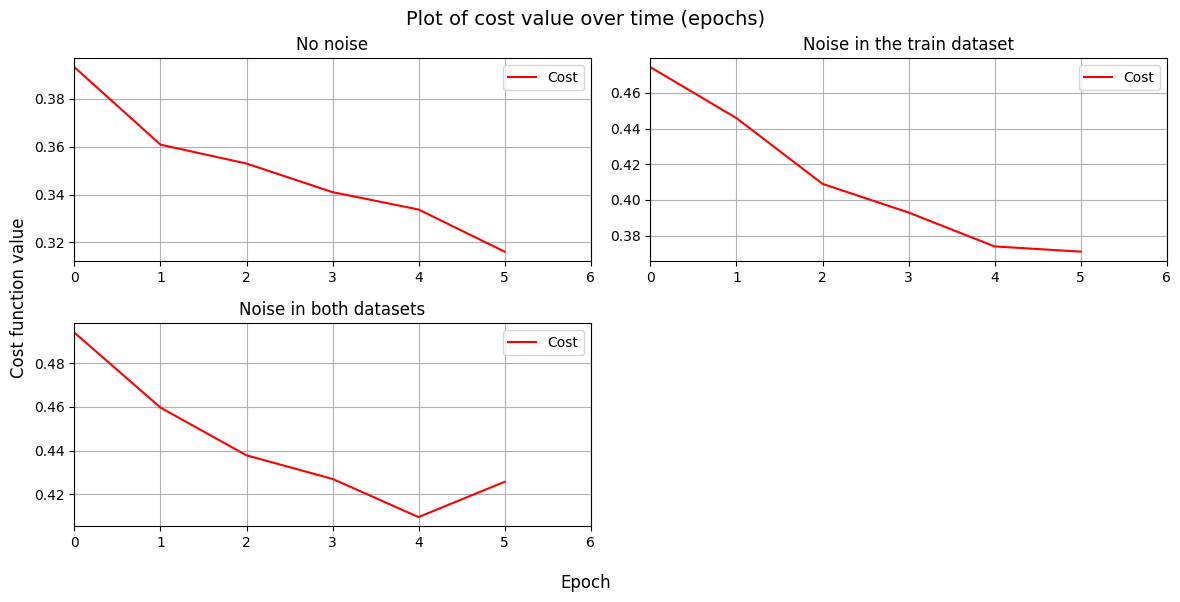

In [ ]:
results_1 = filter_results(
    subset_size = 1.0,
    batch_size=12,
    layer_dims = [784, 64, 10],
    train_noise_std=0.0,
    val_noise_std=0.0
)
results_2 = filter_results(
    subset_size = 1.0,
    batch_size=12,
    layer_dims = [784, 64, 10],
    train_noise_std=0.2,
    val_noise_std=0.0
)
results_3 = filter_results(
    subset_size = 1.0,
    batch_size=12,
    layer_dims = [784, 64, 10],
    train_noise_std=0.2,
    val_noise_std=0.2
)

results_with_titles = [
    (results_1.results, "No noise"),
    (results_2.results, "Noise in the train dataset"),
    (results_3.results, "Noise in both datasets"),
]

compare_plots(results_with_titles)
compare_plots(results_with_titles, cost=True)

#### Analysis
In the "no noise" scenario, all three metrics show a steady improvement over the training epochs, reaching high values at the end. In the 'noise in the training dataset' scenario, the metrics start lower but also improve over time, although not as dramatically as in the 'no noise' case. The presence of noise in the training dataset has a negative impact on the performance of the model, but the model is still able to learn and improve. In the last pair of graphs we can see how badly noise can affect both datasets.